# Introduction

- In this assignment, you will modify the fully-connected neural networks and convolutional neural networks we built in our previous classes. You will also work on a different dataset. Our task is to classify the images in four categories; **rainy, shiny,sunrise and cloudy**. I sampled the data from [here](https://data.mendeley.com/datasets/4drtyfjtfy/1). It is already in your directory, you do not need to do anything.



- Your job is to create and train those models. Feel free to use any trick we have learned so far.Based on the evaluation metrics in section-5, you will write your observations. Make sure to obtain all the metrics for both models.


- Carefully read the notebook and make sure all cells are running properly. To ensure this, click on kernel--> Restart and Run All option on the upper left menu. You will see your questions as you read the notebook. There are three big questions

        (1) In section-2, you will build a fully connected network and convolutional neural network.


        (2) At the end of the notebook, you will write a summary to compare both models.


- **The group training the best model will have 5 extra credit towards the final.** 

## Import necessary modules

In [1]:
%matplotlib inline
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
#============================#
import os
import copy
import random
import sys
from collections import Counter
from torchinfo import summary
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore') 
#===custom functions===========#
from utils import create_train_test,get_data_paths,view_samples,view_class_dist
from utils import train_test_model,load_model
from utils import display_predictions,get_confusion_matrix,plot_confusion_matrix,display_all_scores

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 Super


In [ ]:
#make your code reproducible to some extent
seed=1234
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load and Inspect the Data

In [2]:
#there is not train/test in the original data
data_dir = "weather_data/"
create_train_test(data_dir)

train-test split done!
check weather_data//train and weather_data//test


In [3]:
train_dir = f"{data_dir}/train/"
test_dir = f"{data_dir}/test"
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
#resize the images
width = 128
height = 128
#define necessary transforms to be applied to each batch. conversion to tensor is bare minimum
training_transforms = transforms.Compose([transforms.Resize((width,height)),transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((width,height)),transforms.ToTensor()])


train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

#this is what is loaded in each batch
batch_size = 4
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size)

In [5]:
class_list = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx
print(class_to_idx)

idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
dis_dict = dict(Counter(train_loader.dataset.targets))
class_counts = list(dis_dict.values())

print(class_counts)

{'cloudy': 0, 'rainy': 1, 'shiny': 2, 'sunrise': 3}
[200, 143, 190, 165]


In [6]:
train_image_paths,test_image_paths = get_data_paths(train_dir, test_dir)

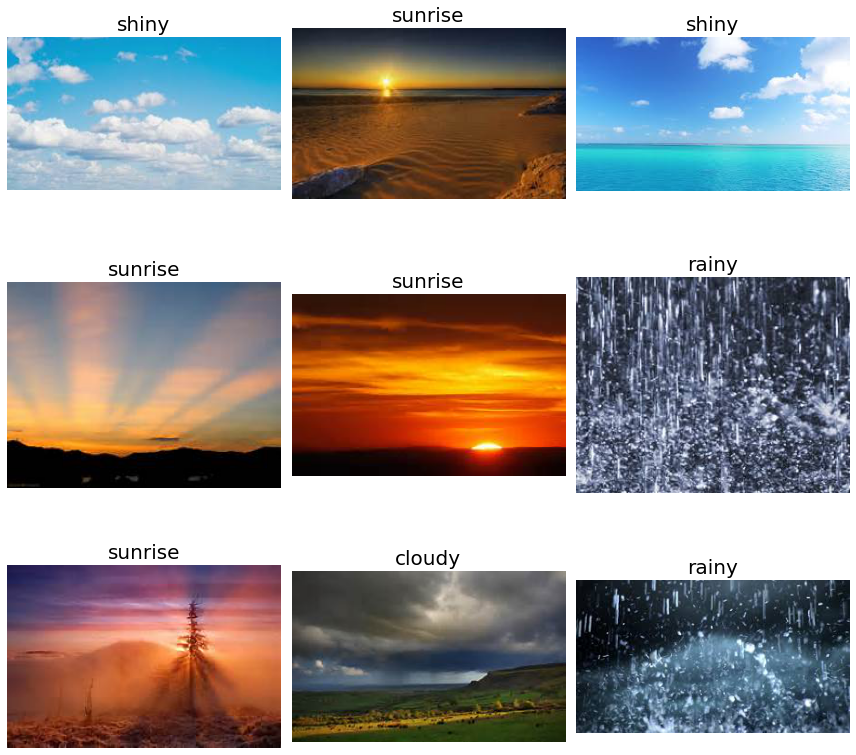

In [7]:
#view some samples
view_samples(3,img_paths=train_image_paths)

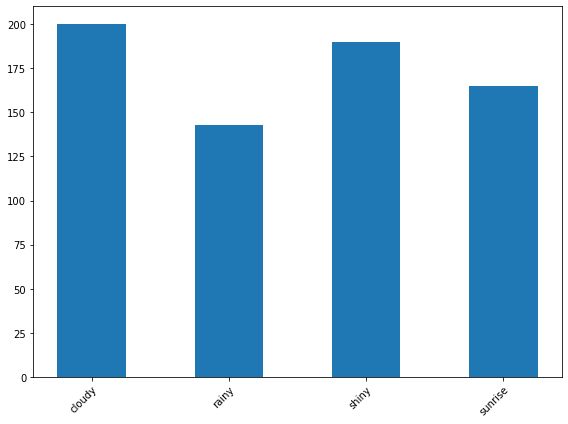

In [8]:
#check the class distribution
view_class_dist(class_list=class_list,class_counts=class_counts)

# Build Two Networks

- Build a fully connected neural network here. We name it as "DenseModel". Build the following model following the our fully-connected notebook. I already worked some of it for you. Just fill out the rest carefully.

            layer-1(input layer):  3*128*128 neurons followed by ReLU activation function
            layer-2:               128 neurons followed by ReLU activation function
            layer-3:               64 neurons followed by ReLU activation function
            layer-4:               32 neurons followed by ReLU activation function
            layer-5(output layer)  4 neurons(numbe of classes)

In [ ]:
def GetLinear(in_features,out_features):
    
    return nn.Sequential( nn.Linear(in_features,out_features),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(out_features)
                      )


class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel,self).__init__()
        
        self.fc1 = GetLinear(3*width*height, 128)
        self.fc2 = GetLinear(128, 64)
        self.fc3 = GetLinear(64, 32)
        #fill out here
        
        
        self.out = nn.Linear(32, num_classes)
            
    def forward(self, t):

        t = torch.flatten(t,1)
        t = self.fc1(t)
        t = self.fc2(t)
        t = self.fc3(t)
        #fill out here
                
        t = self.out(t)
        
        return t

- Check the model architecture here. If the following code does not run, make sure you set up your model properly.

In [ ]:
model = DenseModel()
summary(model,input_size=(1,3,width,height))

- Now you will build a convolutional neural network, we will call it *CnnModel*. As we discussed, a convolutional layer is usually followed by activation function,batch normalization and pooling operation. Similarly fully connected hidden layers are followed by activation function and batch normalization. Following code is an elegant way of building these blocks without typing them again and again. Do not need to change batch norm and max pooling options.

- With the help of those functions build the following network

        CONV-layer-1(input)       3 input channels 128 output channels with kernel size 3 stride 2.
        CONV-layer-2:             128 input channels 64 output channels with kernel size 3 stride 2.
        CONV-layer-3:             64 input channels 32 output channels with kernel size 3 stride 2.
        CONV-layer-4:             32 input channels 16 output channels with kernel size 3 stride 2.

        Dense-layer-1:            32*14*14 neurons
        Dense-layer-2:            64 neurons
        Dense-layer-3:            32 neurons
        Dense-layer-4(output)     4 neurons



In [ ]:
#nice way of building a model using Pytorch containers
def Get2dConv(in_channels,out_channels):
    
    return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(out_channels),
                        nn.MaxPool2d(kernel_size=2,stride=2)
                        )
def GetLinear(in_features,out_features):
    
    return nn.Sequential( nn.Linear(in_features,out_features),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(out_features)
                      )

# Extent nn.Module to create a new model.
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel,self).__init__()
        self.conv1 = Get2dConv(3,128)
        self.conv2 = Get2dConv(128,64)
        self.conv3 = Get2dConv(64,32)
        self.conv4 = Get2dConv(32,16)
        
        self.fc1 = GetLinear(32*14*14,64)
        self.fc2 = GetLinear(64,32)
        
        self.out = nn.Linear(32,num_classes)
     
    
    def forward(self, t):
        t = self.conv1(t)
        t = self.conv2(t)
        t = self.conv3(t)
        
       

        t = torch.flatten(t,1)

        t = self.fc1(t)
        t = self.fc2(t)
        t = self.out(t)
       
        return t

In [ ]:
model = CnnModel()
summary(model,input_size=(1,3,width,height))

# Training and Testing


- Now time to train both models to see which one will perform better. **In both cases, decide the learning rate and number of epochs, maybe you may want to change the batch size at the very top as well.**

In [ ]:
model = DenseModel()
num_epochs = 30
lr = 2e-4
log_int = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name = "best_cnn"
train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int,model_name)

In [ ]:
#train dense model
model = CnnModel()
num_epochs = 30
lr = 2e-4
log_int = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name = "best_cnn"
train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int,model_name)

# Display Predictions

Load both models separately.

In [ ]:
#load dense model
dense_model = load_model(DenseModel(),f"{save_dir}/DenseModel.pth")
print(dense_model.best_scores)

#load cnn model
cnn_model = load_model(CnnModel(),f"{save_dir}/CnnModel.pth")
print(cnn_model.best_scores)

# Evaluate the Model Performance

## Confusion Matrix

- Plot confusion matrix for both model

In [ ]:
#confusion matrix for dense model.Remember how to use this function 
#cm = get_confusion_matrix()
#plot_confusion_matrix()

In [ ]:
#confusion matrix for cnn model.Remember how to use this function 
# cm_cnn = GetConfusionMatrix()
# PlotConfusionMatrix()

## Evaluations Metrics

In [ ]:
#display_all_scores

**Question** Based on the results in this section, comment on the following questions.

(1) Which model is better an why?











(2) Is there any class your models are struggling to recognize? If so, why could be the reason?











(3) Is there any class that your models is particularly confused with? If so, why could be the reason?











(4) Go back to the cell where we load our data and remove *shuffle=True* option and run the entire notebook. You will see an immidate drop in model accuracy. Do some research to explain why this happens. 











**CONTRIBUTION STATEMENT**

Member-1:



Member-2: